# 0.0 Imports

In [1]:
import pandas              as pd
import numpy               as np
import matplotlib.pyplot   as plt
import seaborn             as sns
from sklearn import metrics as m
from sklearn.svm import SVC
from imblearn import combine as c
from boruta                  import BorutaPy
from IPython.core.display    import display, HTML
import inflection
import warnings
warnings.filterwarnings('ignore')
from scipy                   import stats
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics as m
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    warnings.filterwarnings('ignore')
    sns.set()
    
jupyter_settings()

def barplot(a,b,data):
    plot = sns.barplot(x=a, y=b, data=data, edgecolor='k', palette='Blues');
    return plot

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def ml_metrics(model_name, y_true, pred):
    
    accuracy = m.balanced_accuracy_score(y_true, pred)
    precision = m.precision_score(y_true, pred)
    recall = m.recall_score(y_true, pred)
    f1 = m.f1_score(y_true, pred)
    kappa = m.cohen_kappa_score(y_true, pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 2), 
                         'Precision': np.round(precision, 2), 
                         'Recall': np.round(recall, 2),
                         'F1': np.round(f1, 2),
                         'Kappa': np.round(kappa, 2)}, index=[model_name])


def ml_results_cv(model_name, model, x, y):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    mms = MinMaxScaler()
    
    balanced_accuracy = []
    precision = []
    recall = []
    f1 = []
    kappa = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        x_train_cv, x_test_cv = x[train_index], x[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        x_train_cv = mms.fit_transform(x_train_cv)
        x_test_cv = mms.fit_transform(x_test_cv)
        
        model.fit(x_train_cv, y_train_cv)
        pred = model.predict(x_test_cv)

        balanced_accuracy.append(m.balanced_accuracy_score(y_test_cv, pred))
        precision.append(m.precision_score(y_test_cv, pred))
        recall.append(m.recall_score(y_test_cv, pred))
        f1.append(m.f1_score(y_test_cv, pred))
        kappa.append(m.cohen_kappa_score(y_test_cv, pred))
    
    acurracy_mean, acurracy_std = np.round(np.mean(balanced_accuracy), 2), np.round(np.std(balanced_accuracy),2)
    precision_mean, precision_std = np.round(np.mean(precision),2), np.round(np.std(precision),2)
    recall_mean, recall_std = np.round(np.mean(recall),2), np.round(np.std(recall),2)
    f1_mean, f1_std = np.round(np.mean(f1),2), np.round(np.std(f1),2)
    kappa_mean, kappa_std = np.round(np.mean(kappa),2), np.round(np.std(kappa),2)
    
    
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(acurracy_mean, acurracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('data/churn.csv')

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

**RowNumber:** O número da coluna

**CustomerID:** Identificador único do cliente

**Surname:** Sobrenome do cliente.

**CreditScore:** A pontuação de Crédito do cliente para o mercado de consumo.

**Geography:** O país onde o cliente reside.

**Gender:** O gênero do cliente.

**Age:** A idade do cliente.

**Tenure:** Número de anos que o cliente permaneceu ativo.

**Balance:** Valor monetário que o cliente tem em sua conta bancária.

**NumOfProducts:** O número de produtos comprado pelo cliente no banco.

**HasCrCard:** Indica se o cliente possui ou não cartão de crédito.

**IsActiveMember:** Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.

**EstimateSalary:** Estimativa do salário mensal do cliente.

**Exited:** Indica se o cliente está ou não em Churn.

## 1.1 Rename Columns

In [5]:
cols_old = ['RowNumber','CustomerId','Surname','CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

In [6]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

In [7]:
df1.columns = cols_new

In [8]:
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
df1.shape

(10000, 14)

## 1.3 Data Types

In [10]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA

In [11]:
df1.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Fillout Na

There are not Nan values in the dataset

## 1.6 Change Types

In [12]:
#changing the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis.

df1['has_cr_card'] = df1['has_cr_card'].map({1:'yes', 0:'no'})
df1['is_active_member'] = df1['is_active_member'].map({1:'yes', 0:'no'})
df1['exited'] = df1['exited'].map({1:'yes',0:'no'})

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

In [13]:
# Central tendecy - mean, median
# Dispersion - std, min, max, skew, kurtosis

skew = df1.skew()
kurtosis = df1.kurtosis()

In [14]:
metrics = pd.DataFrame(df1.describe().drop(['count','25%','75%']).T)
metrics = pd.concat([metrics, skew, kurtosis], axis=1)
metrics.columns = ['Mean','STD','Min','Median','Max',' Skew','Kurtosis']
metrics

,Mean,STD,Min,Median,Max,Skew,Kurtosis
row_number,5000.500,2886.896,1.000,5000.500,10000.000,0.000,-1.200
customer_id,15690940.569,71936.186,15565701.000,15690738.000,15815690.000,0.001,-1.196
credit_score,650.529,96.653,350.000,652.000,850.000,-0.072,-0.426
age,38.922,10.488,18.000,37.000,92.000,1.011,1.395
tenure,5.013,2.892,0.000,5.000,10.000,0.011,-1.165
balance,76485.889,62397.405,0.000,97198.540,250898.090,-0.141,-1.489
num_of_products,1.530,0.582,1.000,1.000,4.000,0.746,0.583
estimated_salary,100090.240,57510.493,11.580,100193.915,199992.480,0.002,-1.182


### 1.7.2 Categorical Attributes

In [15]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
cat_attributes.apply(lambda x: x.unique().shape[0])

surname             2932
geography              3
gender                 2
has_cr_card            2
is_active_member       2
exited                 2
dtype: int64

In [16]:
cat_attributes.describe()

,surname,geography,gender,has_cr_card,is_active_member,exited
count,10000,10000,10000,10000,10000,10000
unique,2932,3,2,2,2,2
top,Smith,France,Male,yes,yes,no
freq,32,5014,5457,7055,5151,7963


# 2.0 Feature Engineering

In [17]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

## 2.2 Hypotheses List

1. Mulheres entram em churn 30% a mais do que os homens 

2. Pessoas com credit score menor do que 600 entram mais em churn

3. Pessoas com menos de 30 anos entram mais em churn

4. Pessoas com balance menor do que que a média entram mais em churn

5. Pessoas com salário maior do que a média entram menos em churn

6. Pessoas que possuem cartão de crédito e credit score menor do que 600 entram mais em churn

7. Pessoas que permaneceram ativas por mais de 2 anos entram menos em churn

8. Pessoas que não são ativas entram mais em churn

9. Pessoas com mais de 1 produto entram menos em churn

10. Pessoas que possuem cartão de crédito e são ativas entram menos em churn


## 2.3 Feature Engineering

# 3.0 Variables Filtering

In [18]:
df3 = df2.copy()

## 3.1 Rows Filtering

All rows will be used for the analysis.

## 3.2 Columns Selection

In [19]:
# droping columns that won't be usefull
df3.drop(['row_number','customer_id','surname'], axis=1, inplace=True)

# 4.0 EDA 

In [20]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='exited', ylabel='count'>

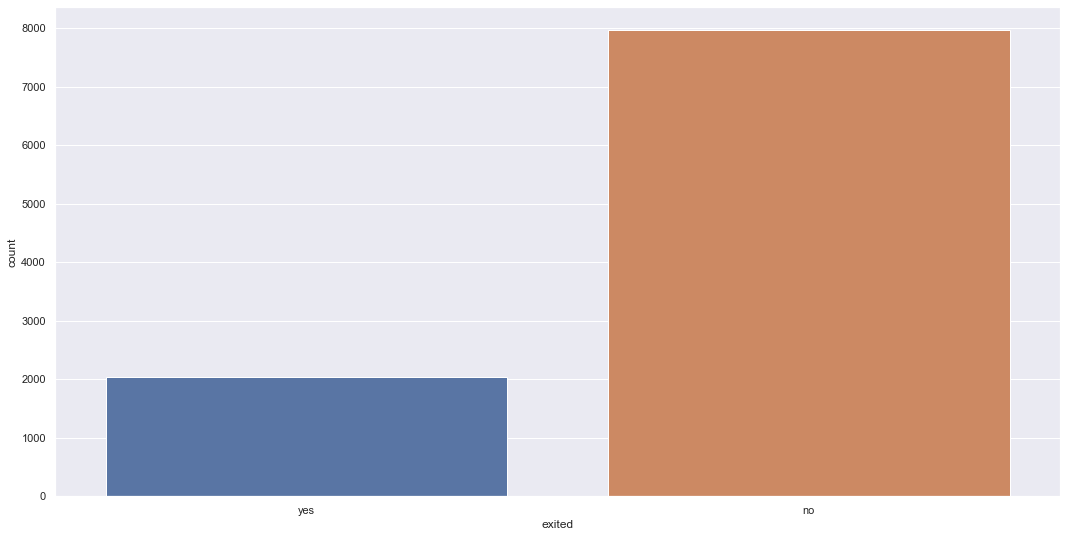

In [21]:
sns.countplot(df4['exited'])

### 4.1.2 Numerical Variables

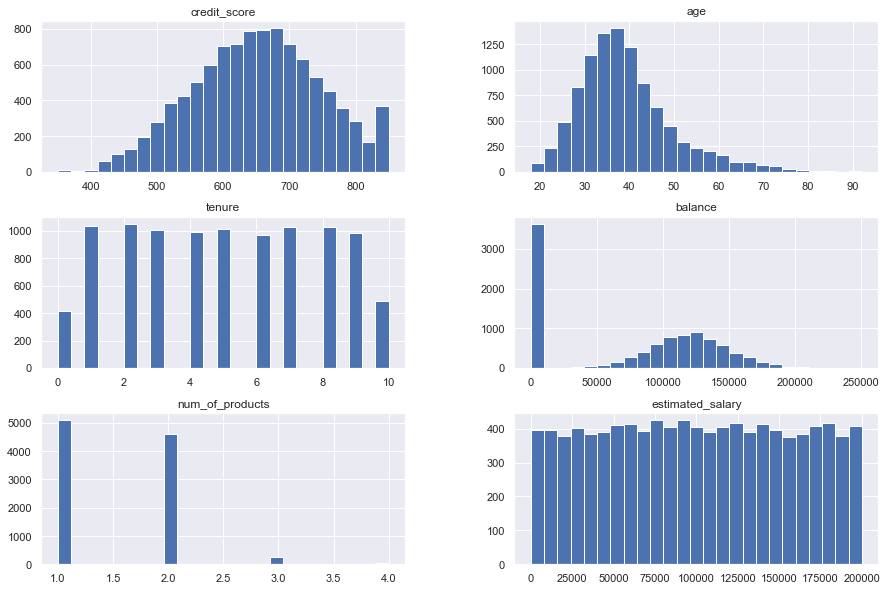

In [22]:
num_atributes = df4.select_dtypes(include=['int64','float64'])

num_atributes.hist(figsize=(15,10), bins=25);

### 4.1.3 Categorical Variables

In [23]:
cat_attributes = df4.select_dtypes(include='object')

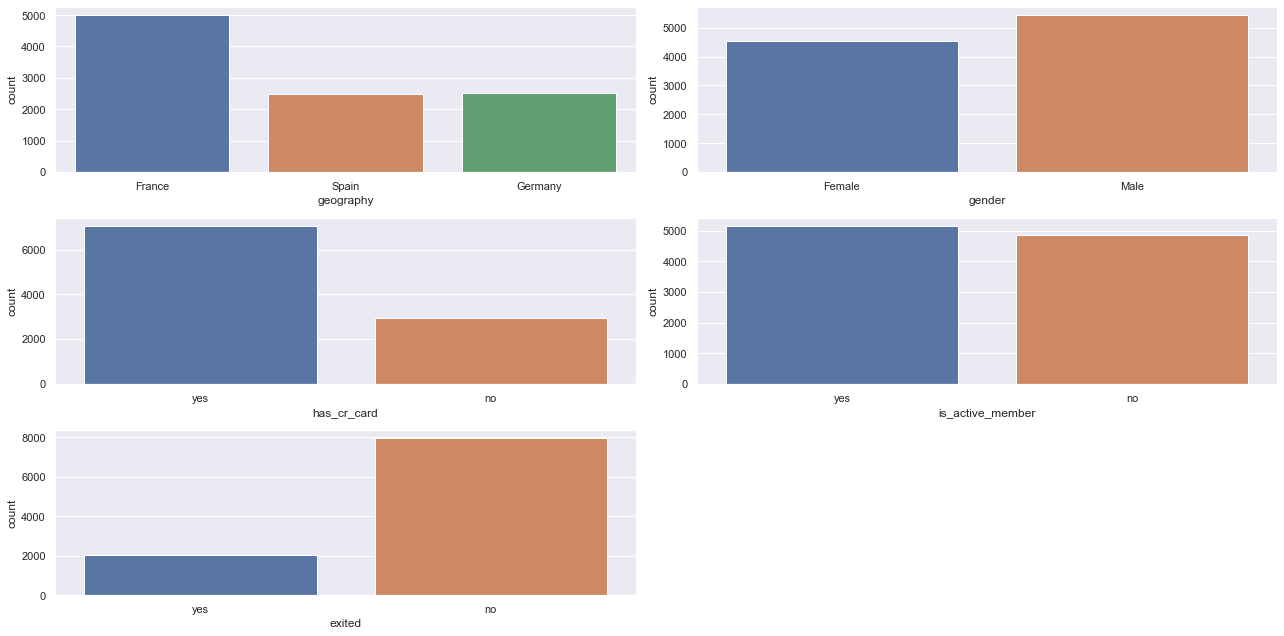

In [24]:
j = 1
for i in cat_attributes:
    plt.subplot(3,2,j)
    sns.countplot(x=i, data=df4)
    plt.tight_layout()
    j +=1

## 4.2 Bivariate Analysis

### **H1.** Mulheres entram em churn 30% a mais do que os homens 
**Falsa!!** Mulheres entram 27% a mais em churn do que homens

In [25]:
aux = df4[['gender','exited']][df4['exited'] == 'yes'].groupby('gender').count().reset_index()
aux.sort_values(by='exited', ascending=True, inplace=True)
aux['growth'] = aux['exited'].pct_change()
aux

,gender,exited,growth
1,Male,898,NaN
0,Female,1139,0.268


<AxesSubplot:xlabel='gender', ylabel='exited'>

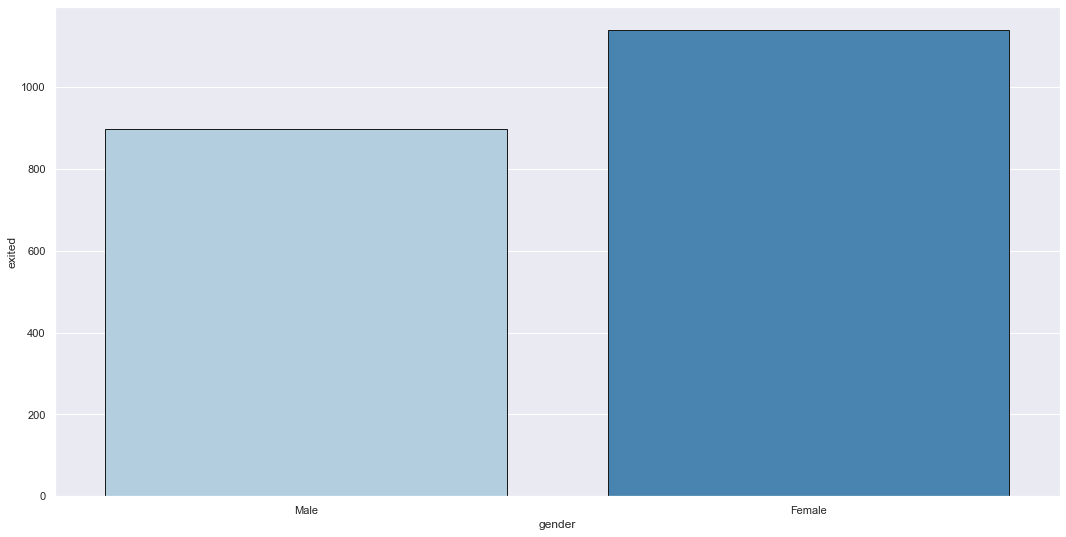

In [26]:
barplot('gender','exited', aux)

### H2. Pessoas com credit score menor do que 600 entram mais em churn
**Falsa!!** Clientes com credit score maior do que 600 entram mais em churn

In [27]:
aux = df4[['credit_score','exited']][df4['exited'] == 'yes'].copy()
aux['credit_score'] = aux['credit_score'].apply(lambda x: '> 600' if x > 600 else '< 600' )
aux1 = aux[['credit_score','exited']].groupby('credit_score').count().reset_index()
aux1

,credit_score,exited
0,< 600,665
1,> 600,1372


<AxesSubplot:xlabel='credit_score', ylabel='exited'>

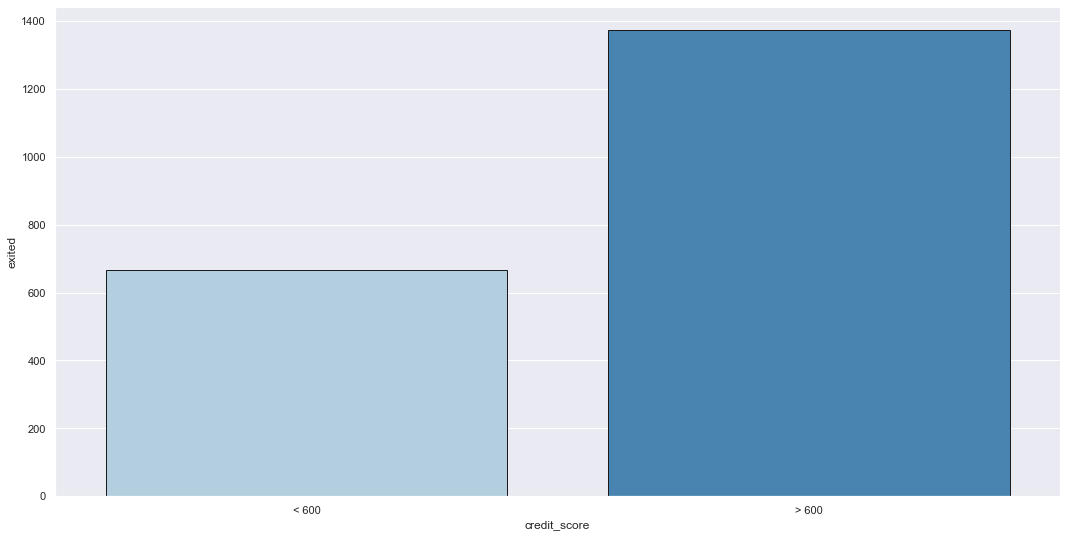

In [28]:
barplot('credit_score','exited',aux1)

### H3. Pessoas com menos de 30 anos entram mais em churn
**Falsa!!** Clientes com menos de 30 anos entram menos em churn

In [29]:
aux = df4[['age','exited']][df4['exited'] == 'yes'].copy()
aux['age'] = aux['age'].apply(lambda x: ' > 30' if x > 30 else ' < 30' )
aux1= aux[['age','exited']].groupby('age').count().reset_index()
aux1

,age,exited
0,< 30,148
1,> 30,1889


<AxesSubplot:xlabel='age', ylabel='exited'>

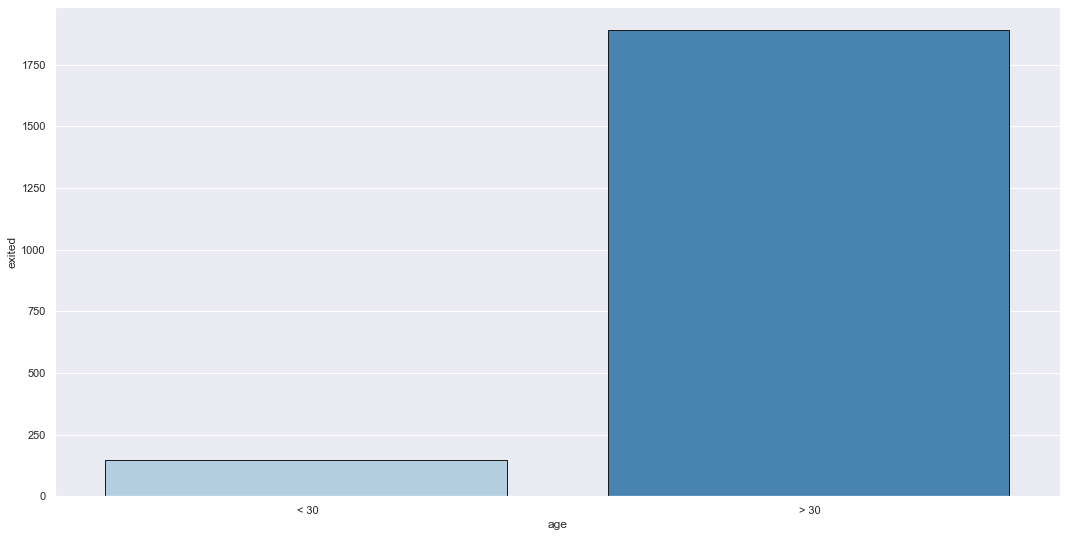

In [30]:
barplot('age','exited', aux1)

### H4. Pessoas com balance menor do que que a média entram mais em churn
**Falsa!!** Clientes com balance menor do que a média entram menos em churn

In [31]:
balance_mean = df4['balance'].mean()
aux = df4[['balance','exited']][df4['exited'] =='yes'].copy()
aux['balance'] = aux['balance'].apply(lambda x: '> mean' if x > balance_mean else '< mean')
aux1 = aux[['balance','exited']].groupby('balance').count().reset_index()
aux1

,balance,exited
0,< mean,611
1,> mean,1426


<AxesSubplot:xlabel='balance', ylabel='exited'>

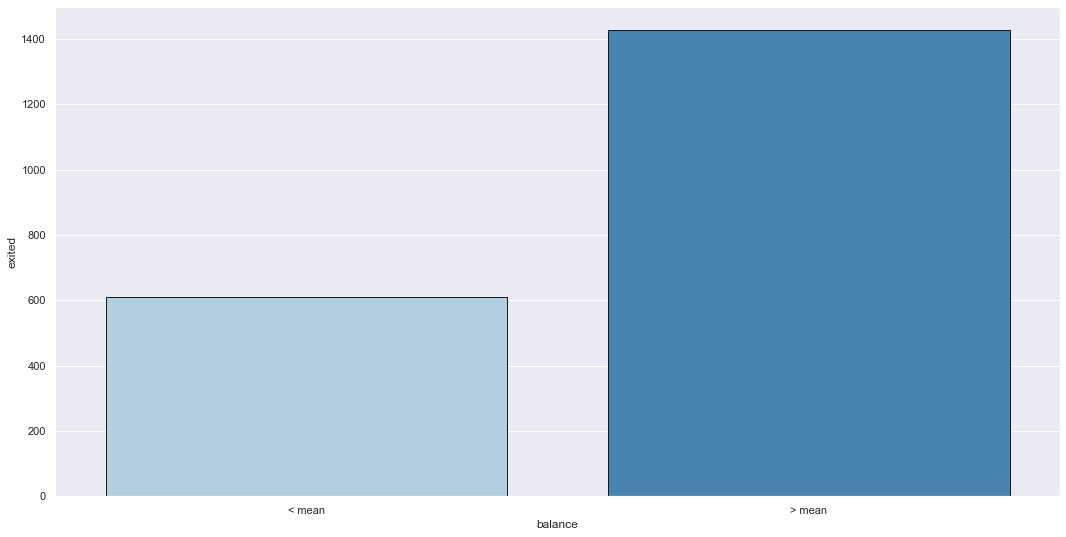

In [32]:
barplot('balance','exited',aux1)

### H5. Pessoas com salário maior do que a média entram menos em churn
**Falsa!!** Pessoas com salário maior do que a média entram mais em churn

In [33]:
mean_salary = df4['estimated_salary'].mean()
aux = df4[['estimated_salary','exited']][df4['exited'] == 'yes'].copy()
aux['estimated_salary'] = aux['estimated_salary'].apply(lambda x: '> mean' if x > mean_salary else '< mean')
aux1 = aux[['estimated_salary','exited']].groupby('estimated_salary').count().reset_index()
aux1

,estimated_salary,exited
0,< mean,995
1,> mean,1042


<AxesSubplot:xlabel='estimated_salary', ylabel='exited'>

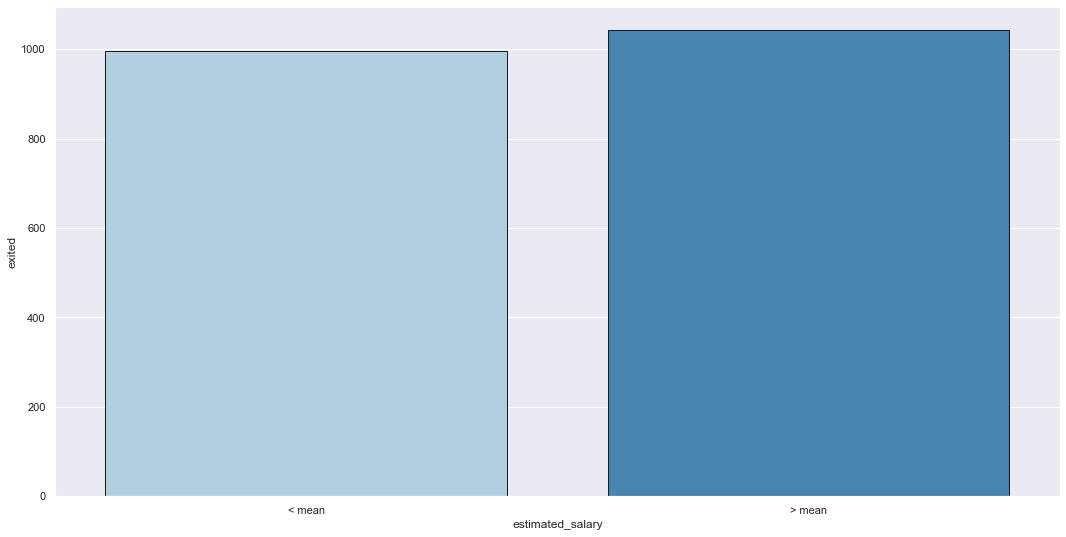

In [34]:
barplot('estimated_salary','exited',aux1)

### H6. Pessoas que possuem cartão de crédito e credit score menor do que 600 entram mais em churn
**Falsa!!** Pessoas que possuem cartão de crédito e score menor do que 600 entram menos em churn

In [35]:
aux = df4[['credit_score','has_cr_card','exited']][(df4['exited'] == 'yes') & (df4['has_cr_card'] == 'yes')].copy()
aux['credit_score'] = aux['credit_score'].apply(lambda x: '> 600' if x > 600 else '< 600' )
aux1 = aux[['credit_score','exited']].groupby('credit_score').count().reset_index()
aux1

,credit_score,exited
0,< 600,462
1,> 600,962


<AxesSubplot:xlabel='credit_score', ylabel='exited'>

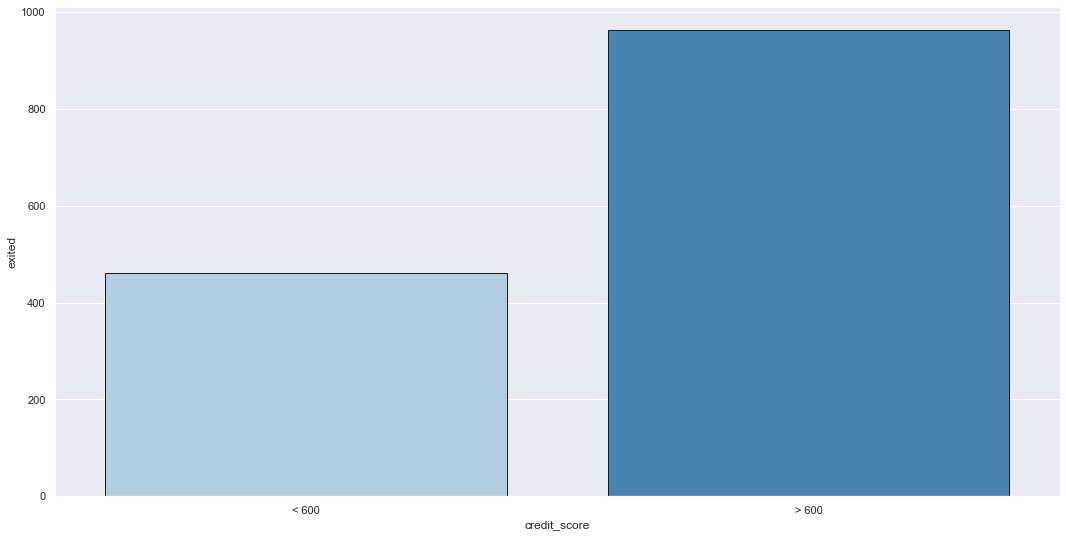

In [36]:
barplot('credit_score','exited',aux1)

### H7. Pessoas que permaneceram ativas por mais de 2 anos entram menos em churn
**Falsa** Pessoas que permaneceram ativas por mais de 2 anos entram mais em churn

In [37]:
aux = df4[['tenure','exited']][(df4['exited'] == 'yes')].copy()
aux['tenure'] = aux['tenure'].apply(lambda x: '> 2' if x > 3 else '< 2')
aux1 = aux[['tenure', 'exited']].groupby('tenure').count().reset_index()
aux1

,tenure,exited
0,< 2,741
1,> 2,1296


<AxesSubplot:xlabel='tenure', ylabel='exited'>

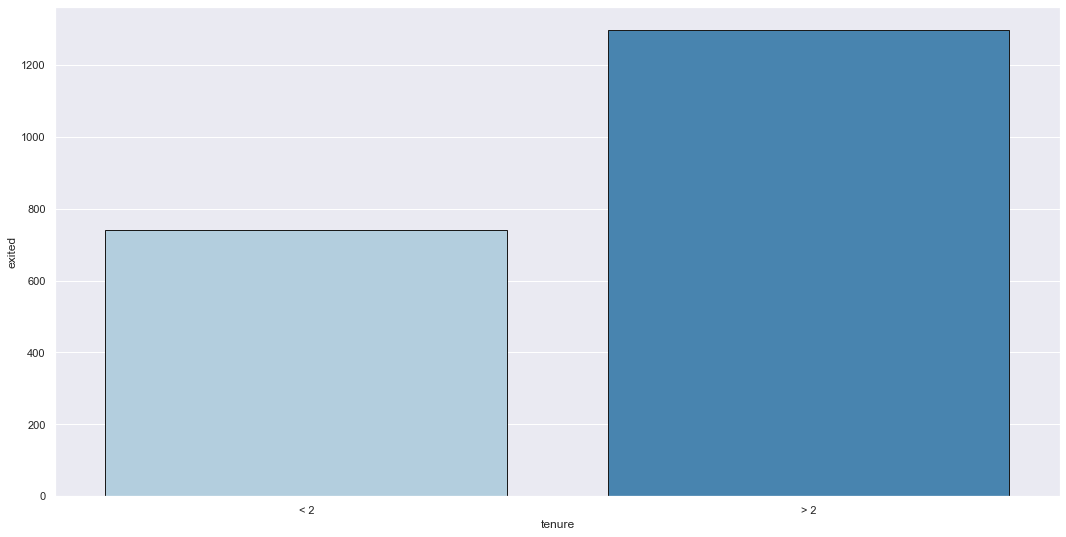

In [38]:
barplot('tenure','exited',aux1)

### H8. Pessoas que não são ativas entram mais em churn
**Verdadeira**

<AxesSubplot:xlabel='is_active_member', ylabel='count'>

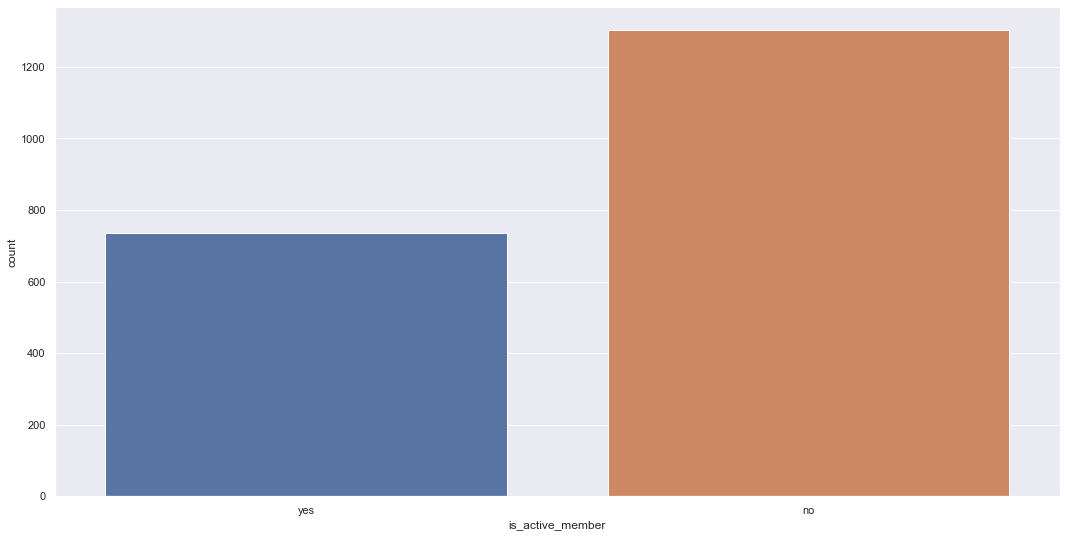

In [39]:
aux = df4[['is_active_member','exited']][df4['exited'] == 'yes'].copy()
sns.countplot(x='is_active_member', data=aux)

### H9. Pessoas com mais de 1 produto entram menos em churn
**Verdadeira**

In [40]:
aux = df4[['num_of_products','exited']][df4['exited']=='yes'].copy()
aux['num_of_products'] = df4['num_of_products'].apply(lambda x: '> 1' if x > 1 else '< 1')
aux1 = aux[['num_of_products','exited']].groupby('num_of_products').count().reset_index()
aux1

,num_of_products,exited
0,< 1,1409
1,> 1,628


<AxesSubplot:xlabel='num_of_products', ylabel='exited'>

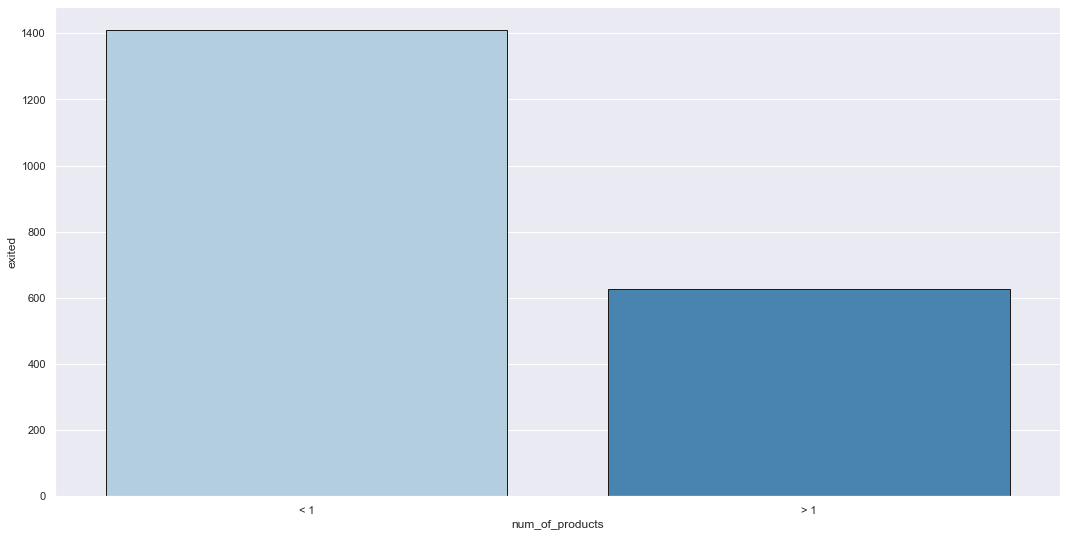

In [41]:
barplot('num_of_products','exited',aux1)

### H10. Pessoas que possuem cartão de crédito e são ativas entram menos em churn
**Falsa** Pesosas que possuem cartão de crédito e são ativas entram mais em churn

<AxesSubplot:xlabel='is_active_member', ylabel='count'>

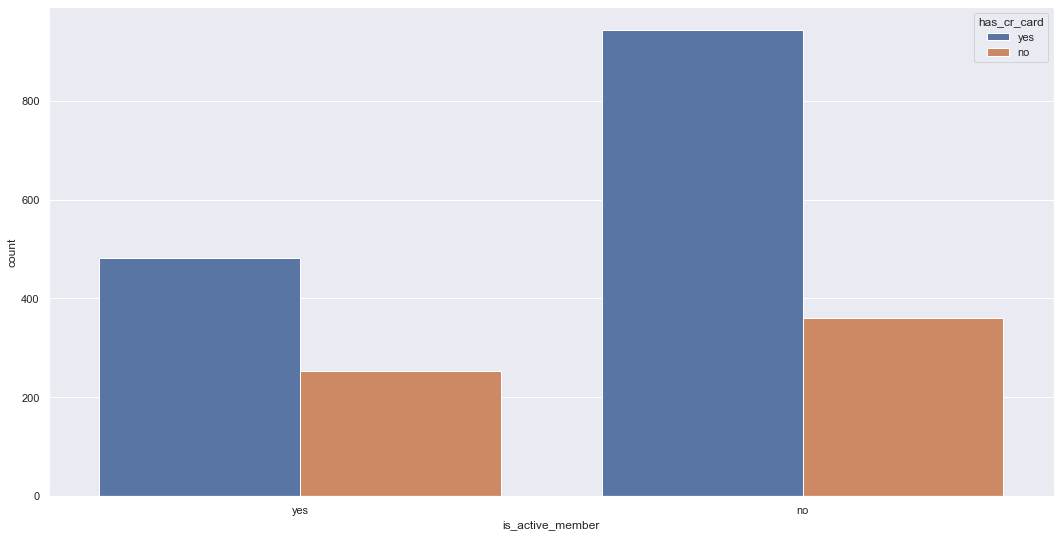

In [42]:
aux = df4[['is_active_member','exited','has_cr_card']][df4['exited'] == 'yes']
sns.countplot(x='is_active_member', hue='has_cr_card', data=aux)

## 4.3 Multivariate Analysis

In [43]:
# changing back to numerical for use in numerical attributes analysis
df4['has_cr_card'] = df4['has_cr_card'].map({'yes':1, 'no':0})
df4['is_active_member'] = df4['is_active_member'].map({'yes':1, 'no':0})
df4['exited'] = df4['exited'].map({'yes':1, 'no':0})

###  4.3.1 Numerical Attributes

In [44]:
num_atributes = df4.select_dtypes(include=['int64','float64'])

<AxesSubplot:>

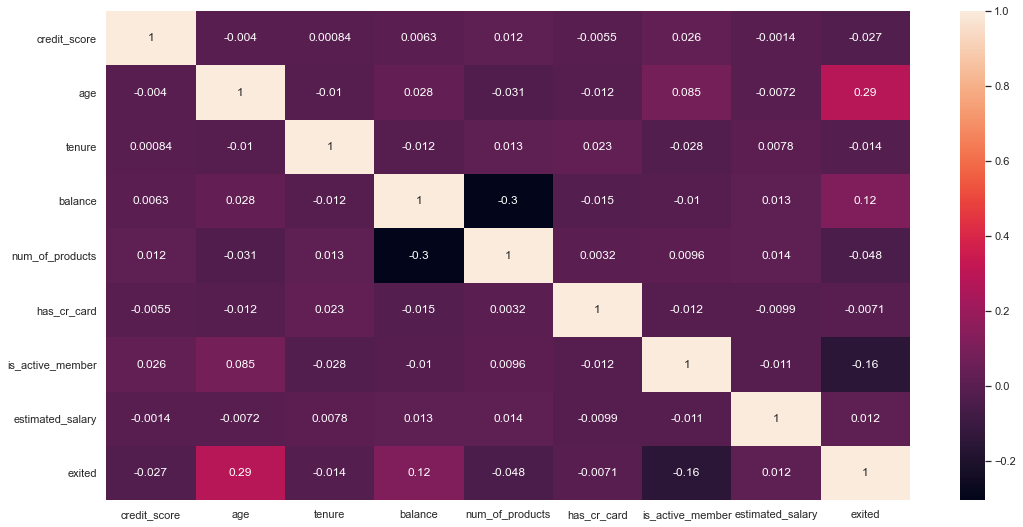

In [45]:
correlation = num_atributes.corr(method='pearson')

sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [46]:
a = df4.select_dtypes(include='object')
a.head()

,geography,gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


In [47]:
# calculate cramer v
a1 = cramer_v(a['geography'], a['gender'])
a2 = cramer_v(a['geography'], a['geography'])

a3 = cramer_v(a['gender'], a['gender'])
a4 = cramer_v(a['gender'], a['geography'])

d = pd.DataFrame({'geography': [a1,a2], 'gender': [a3,a4]})
d.set_index(d.columns)

,geography,gender
geography,0.026,1.000
gender,1.000,0.026


<AxesSubplot:>

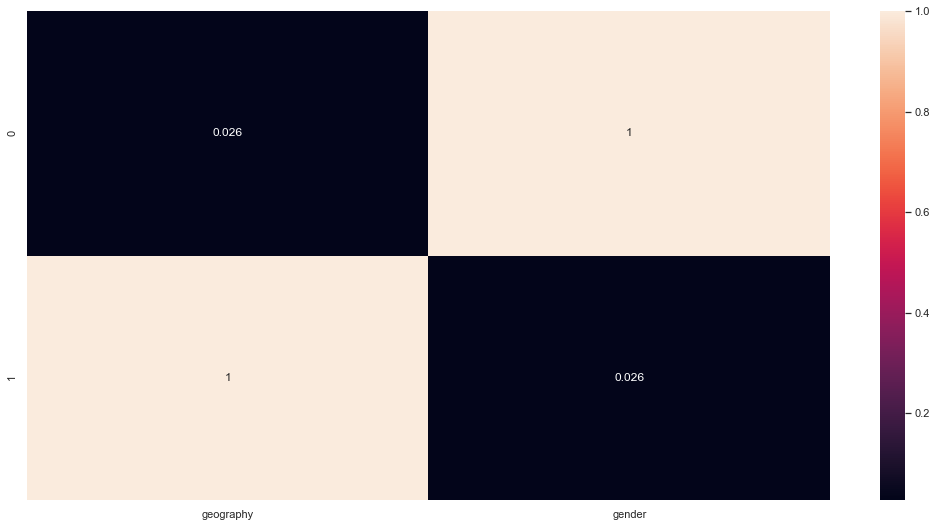

In [48]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [318]:
df5 = df4.copy()

## 5.1 Split dataframe into training, test and validation dataset

In [319]:
X = df5.drop('exited', axis=1).copy()
y = df5['exited'].copy()

In [320]:
# train dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y,train_size=0.8, random_state=42, stratify=y)

In [321]:
# validation, test dataset
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

In [322]:
X_test9 = X_test.copy()
y_test9 = y_test.copy()

## 5.2 Rescaling

In [393]:
mms = MinMaxScaler()
rs = RobustScaler()

# credit score - min-max scaler
X_train['credit_score'] = mms.fit_transform(X_train[['credit_score']].values)
X_test['credit_score'] = mms.fit_transform(X_test[['credit_score']].values)
X_valid['credit_score'] = mms.fit_transform(X_valid[['credit_score']].values)

# age - robust scaler
X_train['age'] = rs.fit_transform(X_train[['age']].values)
X_test['age'] = rs.fit_transform(X_test[['age']].values)
X_valid['age'] = rs.fit_transform(X_valid[['age']].values)

# balance - min-max scaler
X_train['balance'] = mms.fit_transform(X_train[['balance']].values)
X_test['balance'] = mms.fit_transform(X_test[['balance']].values)
X_valid['balance'] = mms.fit_transform(X_valid[['balance']].values)


# estimated salary - min-max scaler
X_train['estimated_salary'] = mms.fit_transform(X_train[['estimated_salary']].values)
X_test['estimated_salary'] = mms.fit_transform(X_test[['estimated_salary']].values)
X_valid['estimated_salary'] = mms.fit_transform(X_valid[['estimated_salary']].values)

# tenure - min-max scaler
X_train['tenure'] = mms.fit_transform(X_train[['tenure']].values)
X_test['tenure'] = mms.fit_transform(X_test[['tenure']].values)
X_valid['tenure'] = mms.fit_transform(X_valid[['tenure']].values)

# num of products - min-max scaler
X_train['num_of_products'] = mms.fit_transform(X_train[['num_of_products']].values)
X_test['num_of_products'] = mms.fit_transform(X_test[['num_of_products']].values)
X_valid['num_of_products'] = mms.fit_transform(X_valid[['num_of_products']].values)

## 5.3 Encoding

In [394]:
le = LabelEncoder()
# gender
dic = {'Female':0, 'Male':1}
X_train['gender'] = X_train['gender'].map(dic)
X_test['gender'] = X_test['gender'].map(dic)
X_valid['gender'] = X_valid['gender'].map(dic)

# geography
X_train['geography'] = le.fit_transform(X_train['geography'])
X_test['geography'] = le.fit_transform(X_test['geography'])
X_valid['geography'] = le.fit_transform(X_valid['geography'])

# 6.0 Feature Selection

## 6.1 Boruta as feature selector

In [57]:
#X_boruta = X_train.values
#y_boruta = y_train.values.ravel()

In [58]:
#rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced')
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
#boruta.fit(X_boruta, y_boruta)

In [59]:
#cols_selected = boruta.support_.tolist()

In [60]:
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

In [61]:
cols_selected_boruta = ['age', 'balance', 'num_of_products']

## 6.2 Feature Importance

In [62]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importance = rf.feature_importances_

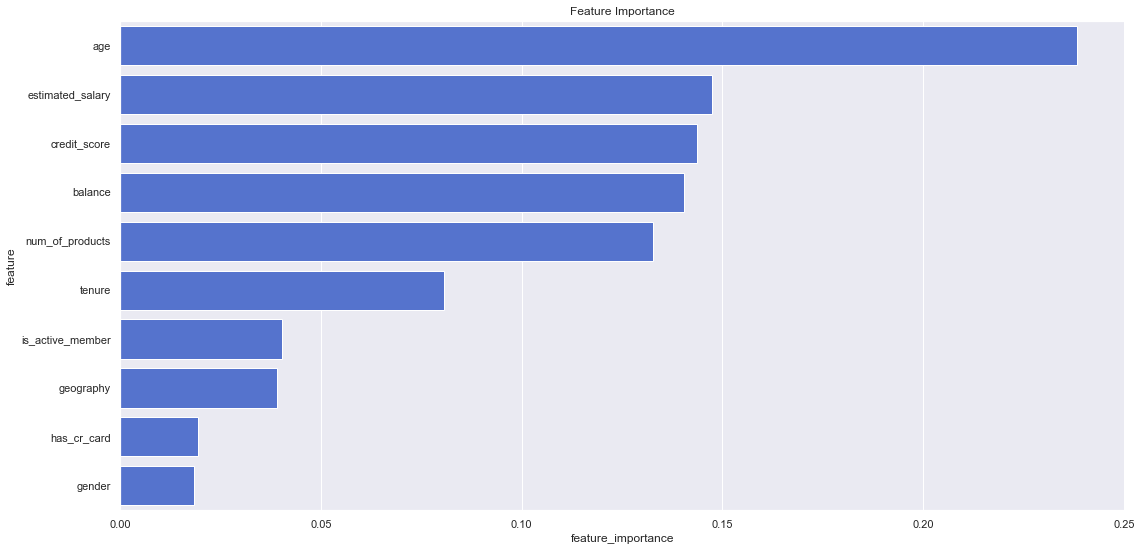

In [63]:
for i,v in enumerate(importance):
    ('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feature_importance = pd.DataFrame({'feature':X_train.columns,
                                  'feature_importance':importance}).sort_values('feature_importance', ascending=False).reset_index()
sns.barplot(x='feature_importance', y='feature', data=feature_importance, orient='h', color='royalblue').set_title('Feature Importance');

In [64]:
cols_selected_importance = feature_importance['feature'].head(6).copy()
cols_selected_importance = cols_selected_importance.tolist()

## 6.3 Columns Selected

 - As colunas selecinadas para treinar o modelo serão as selecionadas pelo boruta e as 6 melhores classificadas com o Random Forest

In [65]:
cols_selected_importance

['age',
 'estimated_salary',
 'credit_score',
 'balance',
 'num_of_products',
 'tenure']

In [66]:
cols_selected_boruta

['age', 'balance', 'num_of_products']

In [395]:
#cols_selected = ['age', 'balance', 'num_of_products', 'estimated_salary', 'credit_score','tenure']
cols_selected = ['age', 'balance', 'num_of_products', 'estimated_salary', 'credit_score','tenure','is_active_member','gender','has_cr_card','geography']

# 7.0 Machine Learning Modeling

In [396]:
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]
X_valid = X_valid[cols_selected]

### 7.0.1 SMOTETomek

In [265]:
#smt = c.SMOTETomek(random_state=42, sampling_strategy='auto', n_jobs=-1)
#X_res_train, y_res_train = smt.fit_resample(X_train, y_train)
#X_res_test, y_res_test = smt.fit_resample(X_test, y_test)
#X_res_valid, y_res_valid = smt.fit_resample(X_valid, y_valid)

## 7.1 Baseline Model

In [266]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
pred = dummy.predict(X_valid)

In [267]:
print(m.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       796
           1       0.00      0.00      0.00       204

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.80      0.71      1000



In [268]:
dummy_result = ml_metrics('dummy', y_valid, pred)
dummy_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000


### Cross Validation

In [269]:
dummy_result_cv = ml_results_cv('dummy_CV', DummyClassifier(), X_train, y_train)
dummy_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy_CV,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [270]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train, y_train)
pred = lg.predict(X_valid)

In [271]:
print(m.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       796
           1       0.39      0.73      0.51       204

    accuracy                           0.71      1000
   macro avg       0.65      0.72      0.65      1000
weighted avg       0.80      0.71      0.73      1000



In [272]:
logistic_regression_result = ml_metrics('LogisticRegression', y_valid, pred)
logistic_regression_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
LogisticRegression,0.720,0.390,0.730,0.510,0.320


### Cross Validation

In [273]:
logistic_regression_result_cv = ml_results_cv('LogisticRegression_CV', LogisticRegression(class_weight='balanced'), X_train, y_train)
logistic_regression_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
LogisticRegression_CV,0.69 +/- 0.02,0.35 +/- 0.01,0.73 +/- 0.07,0.47 +/- 0.01,0.27 +/- 0.02


## 7.3 KNN

In [274]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_valid)

In [275]:
print(m.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       796
           1       0.63      0.29      0.40       204

    accuracy                           0.82      1000
   macro avg       0.73      0.62      0.65      1000
weighted avg       0.80      0.82      0.79      1000



In [276]:
knn_result = ml_metrics('KNN', y_valid, pred)
knn_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
KNN,0.620,0.630,0.290,0.400,0.310


### Cross Validaton

In [277]:
knn_result_cv = ml_results_cv('KNN_CV', KNeighborsClassifier(), X_train, y_train)
knn_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
KNN_CV,0.63 +/- 0.02,0.56 +/- 0.03,0.32 +/- 0.03,0.41 +/- 0.03,0.3 +/- 0.03


## 7.4 Naive Bayes

In [278]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_valid)

In [279]:
print(m.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       796
           1       0.83      0.22      0.34       204

    accuracy                           0.83      1000
   macro avg       0.83      0.60      0.62      1000
weighted avg       0.83      0.83      0.79      1000



In [280]:
naive_bayes_result = ml_metrics('Naive Bayes', y_valid, pred)
naive_bayes_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
Naive Bayes,0.600,0.830,0.220,0.340,0.280


### Cross Validation

In [281]:
naive_bayes_result_cv = ml_results_cv('Naive Bayes_CV', GaussianNB(), X_train, y_train)
naive_bayes_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Naive Bayes_CV,0.63 +/- 0.02,0.68 +/- 0.04,0.3 +/- 0.06,0.41 +/- 0.05,0.33 +/- 0.05


## 7.5 SVC

In [282]:
svc = SVC(class_weight='balanced')
svc.fit(X_train, y_train)
pred = svc.predict(X_res_valid)

In [283]:
svc_result = ml_metrics('SVC', y_valid, pred)
svc_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVC,0.740,0.470,0.680,0.550,0.410


### Cross Validation

In [284]:
svc_result_cv = ml_results_cv('SVC_cv', SVC(class_weight='balanced'), X_train, y_train)
svc_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVC_cv,0.75 +/- 0.02,0.44 +/- 0.02,0.74 +/- 0.06,0.55 +/- 0.02,0.4 +/- 0.02


## 7.6 Random Forest

In [285]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
pred = rf.predict(X_valid)

In [286]:
pred_proba = rf.predict_proba(X_valid)

In [287]:
print(m.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       796
           1       0.83      0.43      0.57       204

    accuracy                           0.87      1000
   macro avg       0.85      0.70      0.74      1000
weighted avg       0.86      0.87      0.85      1000



In [288]:
rf_result = ml_metrics('Random Forest', y_valid, pred)
rf_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.700,0.830,0.430,0.570,0.500


### Cross Validation

In [289]:
rf_result_cv = ml_results_cv('Random Forest_CV', RandomForestClassifier(class_weight='balanced'), X_train, y_train)
rf_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest_CV,0.7 +/- 0.02,0.7 +/- 0.05,0.45 +/- 0.04,0.54 +/- 0.02,0.46 +/- 0.02


## 7.7 XGBoost

In [290]:
xgb = XGBClassifier(scale_pos_weight=80, objective='binary:logistic', verbosity=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_valid)

In [291]:
xgb_result = ml_metrics('XGBoost', y_valid, pred)
xgb_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.720,0.370,0.780,0.510,0.320


In [292]:
print(m.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77       796
           1       0.37      0.78      0.51       204

    accuracy                           0.69      1000
   macro avg       0.65      0.72      0.64      1000
weighted avg       0.81      0.69      0.72      1000



In [293]:
xgb_result = ml_metrics('XGBoost', y_valid, pred)
xgb_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.720,0.370,0.780,0.510,0.320


### Cross Validation

In [294]:
xbg_result_cv = ml_results_cv('XGBoost_CV', XGBClassifier(scale_pos_weight=80, objective='binary:logistic', verbosity=0), X_train, y_train)
xbg_result_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost_CV,0.73 +/- 0.01,0.38 +/- 0.01,0.79 +/- 0.02,0.51 +/- 0.01,0.32 +/- 0.02


## 7.8 Results

In [295]:
df_results = pd.concat([dummy_result, logistic_regression_result, knn_result, naive_bayes_result, svc_result, rf_result, xgb_result])
df_results.style.highlight_max(color='lightgreen', axis=0)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500000,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.720000,0.390000,0.730000,0.510000,0.320000
KNN,0.620000,0.630000,0.290000,0.400000,0.310000
Naive Bayes,0.600000,0.830000,0.220000,0.340000,0.280000
SVC,0.740000,0.470000,0.680000,0.550000,0.410000
Random Forest,0.700000,0.830000,0.430000,0.570000,0.500000
XGBoost,0.720000,0.370000,0.780000,0.510000,0.320000


## 7.9 Results Cross Validation

In [296]:
df_results_cv = pd.concat([dummy_result_cv, logistic_regression_result_cv, knn_result_cv, naive_bayes_result_cv, svc_result_cv, rf_result_cv, xbg_result_cv])
df_results_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy_CV,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
LogisticRegression_CV,0.69 +/- 0.02,0.35 +/- 0.01,0.73 +/- 0.07,0.47 +/- 0.01,0.27 +/- 0.02
KNN_CV,0.63 +/- 0.02,0.56 +/- 0.03,0.32 +/- 0.03,0.41 +/- 0.03,0.3 +/- 0.03
Naive Bayes_CV,0.63 +/- 0.02,0.68 +/- 0.04,0.3 +/- 0.06,0.41 +/- 0.05,0.33 +/- 0.05
SVC_cv,0.75 +/- 0.02,0.44 +/- 0.02,0.74 +/- 0.06,0.55 +/- 0.02,0.4 +/- 0.02
Random Forest_CV,0.7 +/- 0.02,0.7 +/- 0.05,0.45 +/- 0.04,0.54 +/- 0.02,0.46 +/- 0.02
XGBoost_CV,0.73 +/- 0.01,0.38 +/- 0.01,0.79 +/- 0.02,0.51 +/- 0.01,0.32 +/- 0.02


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [297]:
# setting some parameters for testing

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# eta
eta = [0.01,0.03]
# subsample
subsample = [0.1,0.5,0.7]
# cols sample
colssample_bytree = [0.3,0.7,0.9]
# min_child_weight
min_child_weight = [3,8,15]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'eta': eta,
               'subsample': subsample,
               'colssample_bytree': colssample_bytree,
               'min_child_weight': min_child_weight}

In [298]:
xgb_grid = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgb_grid, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#xgb_random.fit(X_train, y_train)

In [299]:
#xgb_random.best_params_

In [300]:
best_params = {'subsample': 0.7,
 'n_estimators': 1000,
 'min_child_weight': 3,
 'max_depth': 30,
 'eta': 0.03,
 'colssample_bytree': 0.7}

## 8.2 Results

In [301]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators = 1000, eta=0.03, subsample = 0.7, min_child_weight = 3, max_depth = 30, colssample_bytree = 0.7, scale_pos_weight=80, verbosity=0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_valid)

In [302]:
xgb_result = ml_metrics('XGBoost', y_valid, pred)
xgb_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.770,0.570,0.660,0.610,0.500


### Cross Validaton

In [303]:
xgboost_cv = ml_results_cv('XGBoost_CV', XGBClassifier(objective='binary:logistic', n_estimators = 1000, eta=0.03, subsample = 0.7, min_child_weight = 3, max_depth = 30, colssample_bytree = 0.7 , scale_pos_weight=80, verbosity=0), 
                             X_train, y_train)
xgboost_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost_CV,0.75 +/- 0.01,0.5 +/- 0.03,0.66 +/- 0.04,0.57 +/- 0.01,0.44 +/- 0.01


# 9.0 Conclusions

## 9.1 Final Model

In [397]:
# model performance with unseen data
xgb_final_model = XGBClassifier(objective='binary:logistic', n_estimators = 1000, eta=0.03, subsample = 0.7, min_child_weight = 3, max_depth = 30, colssample_bytree = 0.7, scale_pos_weight=80, verbosity=0)
xgb_final_model.fit(X_train, y_train)
pred_final = xgb_final_model.predict(X_test)
pred_final_proba = xgb_final_model.predict_proba(X_test)

xgb_final_model_result = ml_metrics('XGBoost', y_test, pred_final)
xgb_final_model_result

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.760,0.540,0.670,0.600,0.480


# 9.2 Business Questions

In [305]:
df9 = df2.copy()

### 9.2.1 Qual a taxa atual de Churn da TopBank? 

In [306]:
churn_rate = df9['exited'].value_counts(normalize=True).reset_index()
churn_rate['exited'] = churn_rate['exited']*100
churn_rate.columns = ['churn', 'exited (%)']
churn_rate

,churn,exited (%)
0,no,79.630
1,yes,20.370


Text(0.5, 1.0, 'Churn Rate')

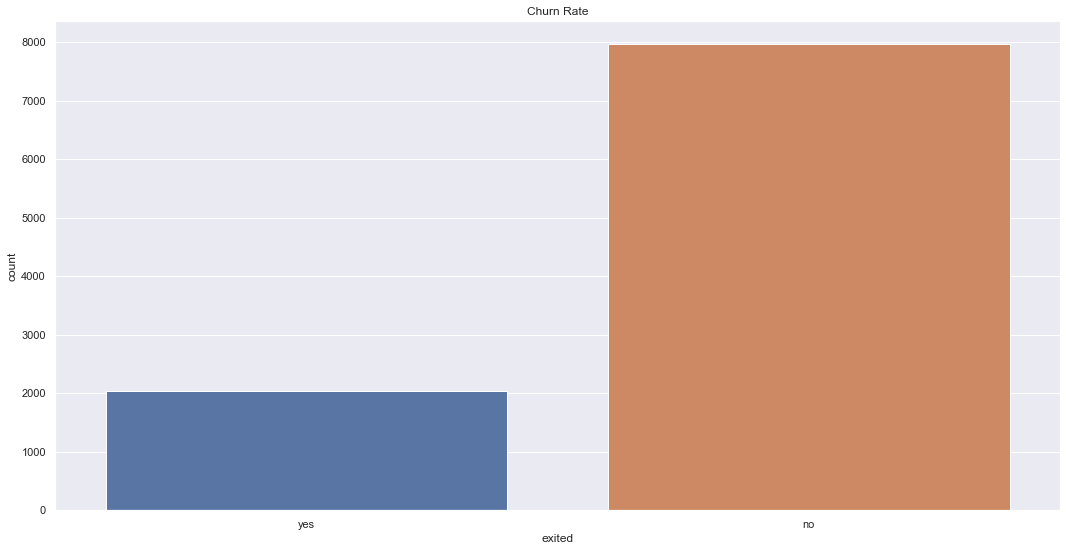

In [307]:
sns.countplot(df9['exited']).set_title('Churn Rate')

**A taxa atual de churn do TopBank é de 20.4%**

### 9.2.2 Como o churn varia mensalmente?

<AxesSubplot:xlabel='tenure', ylabel='count'>

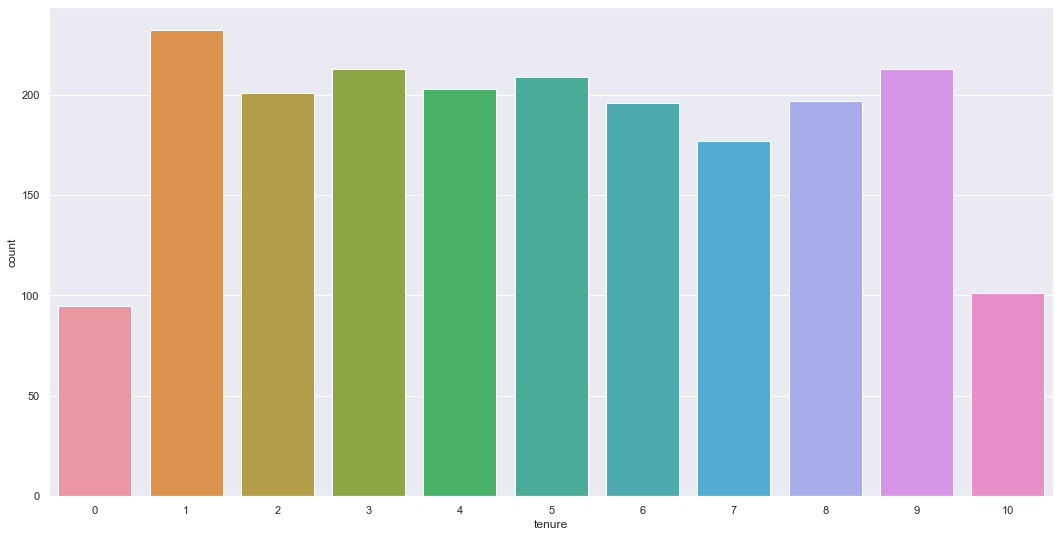

In [308]:
chur_month_rate = df9[df9['exited'] == 'yes']['tenure']
sns.countplot(chur_month_rate)

### 9.2.3 Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

 - Para realização do cálculo de retorno financeiro foi utilizado uma amostra de 1000 clientes (10% do dataset). 
 - Para comparação com os dados reais foram utlizados os valores da predição final do modelo.
 

In [438]:
aux = pd.concat([X_test9, y_test9], axis=1)
mean_salary = df9['estimated_salary'].mean()

In [439]:
aux['pred_exited'] = pred_final

In [440]:
aux['client_return'] = aux['estimated_salary'].apply(lambda x: x*0.15 if x < mean_salary else x*0.20)

 - Cálculo do retorno total para todos os clintes que entraram em churn na amostra

In [441]:
total_return = aux[aux['exited'] == 1]['client_return'].sum()
print('O retorno total de todos os clientes que entraram em churn é de ${}' .format(total_return))

O retorno total de todos os clientes que entraram em churn é de $3658649.9845000003


-  Selecionando os clientes que o modelo previu corretamente que entraram em churn. 
- Se fosse possível evitar que todos os clientes entrassem em churn seria possível recuperar aproximadamente 70% do valor total calculado acima. 

In [442]:
churn_return = aux[(aux['pred_exited'] == 1) & (aux['exited'] == 1)]['client_return'].sum()
print('O retorno total  dos clientes que o modelo previu que entrariam em churn é de ${}' .format(churn_return))

O retorno total  dos clientes que o modelo previu que entrariam em churn é de $2540855.073


### 9.2.4 Incentivo Financeiro

Uma possível ação para evitar que o cliente entre em churn é oferecer um cupom de desconto, ou algum outro incentivo financeiro para ele renovar seu contrato por mais 12 meses.
- Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os $10.000,00

Ainda levando em conta a amostra de 1000 clientes, foi possível analisar a probabilidade de cada cliente entrar em churn segundo o algoritmo e decidir de qual forma o incentivo finaceiro seria oferecido. Após algumas análises foram definidas as seguintes estratágias (foram considerados apenas clientes que o algoritmo previu como "positivos" para o churn):

- Foi definido um ponto de corte (threshold) de 0.95, ou seja, a probabilidade dos clientes entrarem em churn foi comparada com esse ponto de corte e a partir disso foram definidos "grupos" que receberiam o incentivo.

    - Clientes com uma probabilidade de mais de 95% não receberiam o incentivo, pois foi considerado que possuem uma probabilidade muito grande a entrarem em churn e seria   muito difícil convence-los a renovar o contrato mesmo com um incentivo finaceiro. 
    - Clientes com uma probabilidade maior do que 90% e menor do que 95% receberiam um incentivo de 250.
    - Clientes com uma probabilidade entre 90% e 70% receberiam um incentivo de 200.
    - Clientes com uma probabilidade menor do que 70% receberiam um incentivo de 100.

In [507]:
threshold = 0.95

In [474]:
proba_list = []
for i in range (len(pred_final_proba)):
    proba = pred_final_proba[i][1]
    proba_list.append(proba)

In [476]:
aux['pred_exited_proba'] = proba_list

In [536]:
aux2 = aux[(aux['exited'] == 1) & (aux['pred_exited'] ==1)]

In [537]:
aux2 = aux2[aux2['pred_exited_proba'] < threshold]

In [543]:
# definindo incentivo de acordo com a probabilidade de churn 
aux2['destinated_budget'] = aux2['pred_exited_proba'].apply(lambda x: 250 if x > 0.9 else 200 if ((x < 0.9) & (x > 0.7)) else 100 )

- Supondo que fosse possível evitar que todos os clientes que receberam o incentivo entrassem em churn, e então consequentemente renovassem seus contratos, seria possível obter um retorno finaceiro de $ 938.235,39

In [550]:
total_return = aux2['client_return'].sum()
print('O Retorno financeiro total a partir dos clientes que receberam o incentivo foi de $ {}'.format(total_return))

O Retorno financeiro total a partir dos clientes que receberam o incentivo foi de $ 938235.3895
